In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
import xgboost as xgb


In [ ]:
df = pd.read_csv(r"\\studata08\home\LI\Liq23sc\ManW10\Downloads\Solar_Energy_Production.csv")
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df.head()

,name,id,address,kWh,public_url,installationDate,uid
date,,,,,,,
2017-11-09 08:00:00,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,1.130,https://monitoring.solaredge.com/solaredge-web...,07/11/2016,3141062017-09-11 08:00:00
2017-11-09 09:00:00,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2.340,https://monitoring.solaredge.com/solaredge-web...,07/11/2016,3141062017-09-11 09:00:00
2017-11-09 10:00:00,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,3.656,https://monitoring.solaredge.com/solaredge-web...,07/11/2016,3141062017-09-11 10:00:00
2017-11-09 11:00:00,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,4.577,https://monitoring.solaredge.com/solaredge-web...,07/11/2016,3141062017-09-11 11:00:00
2017-11-09 12:00:00,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,6.506,https://monitoring.solaredge.com/solaredge-web...,07/11/2016,3141062017-09-11 12:00:00


## EDA

In [ ]:
df['name'].value_counts()

Southland Leisure Centre                     36244
Whitehorn Multi-Service Centre               32551
City of Calgary North Corporate Warehouse    31798
Richmond - Knob Hill Community Hall          31175
Calgary Fire Hall Headquarters               30246
Glenmore Water Treatment Plant               30028
Bearspaw Water Treatment Plant               29404
CFD Firehall #7                              27309
Manchester Building M                        26968
Hillhurst Sunnyside Community Association    25191
Telus Spark                                    317
Name: name, dtype: int64

In [ ]:
#solar energy production per site
ttl_kwh = df.groupby('name')['kWh'].sum()

plants_energy_production = pd.DataFrame(ttl_kwh).sort_values(by='kWh', ascending=False)

plants_energy_production.style.background_gradient(cmap='cool')


,kWh
name,
Bearspaw Water Treatment Plant,111808536.546000
Whitehorn Multi-Service Centre,65508688.243000
Southland Leisure Centre,25811559.291000
Glenmore Water Treatment Plant,22979711.898000
City of Calgary North Corporate Warehouse,18437735.757000
CFD Firehall #7,4710587.817000
Manchester Building M,3802022.057000
Calgary Fire Hall Headquarters,3062372.369000
Richmond - Knob Hill Community Hall,2826658.145000


In [ ]:
#Calgary FHH hourly production
calgary = df[df['name']== 'Calgary Fire Hall Headquarters']
hourly_production = pd.DataFrame(calgary['kWh'])

hourly_production.head(10).style.background_gradient(cmap='RdBu')

,kWh
date,
2017-11-09 08:00:00,1.130000
2017-11-09 09:00:00,2.340000
2017-11-09 10:00:00,3.656000
2017-11-09 11:00:00,4.577000
2017-11-09 12:00:00,6.506000
2017-11-09 13:00:00,7.031000
2017-11-09 14:00:00,9.218000
2017-11-09 15:00:00,9.018000
2017-11-09 16:00:00,5.266000


In [ ]:
#Calgary FHH daily production
daily_production_0 = hourly_production.groupby(hourly_production.index.date)['kWh'].sum()

daily_production = pd.DataFrame(daily_production_0)


daily_production.head(10).style.background_gradient(cmap='PRGn')

,kWh
2016-02-12,0.005000
2016-11-24,0.297000
2016-11-29,0.130000
2017-01-03,73.531000
2017-01-05,101.143000
2017-01-06,77.869000
2017-01-07,70.457000
2017-01-08,42.882000
2017-01-09,91.189000
2017-01-10,65.096000


## Outlier Removal

<AxesSubplot: title={'center': 'Calgary FHH kWh solar energy daily production'}>

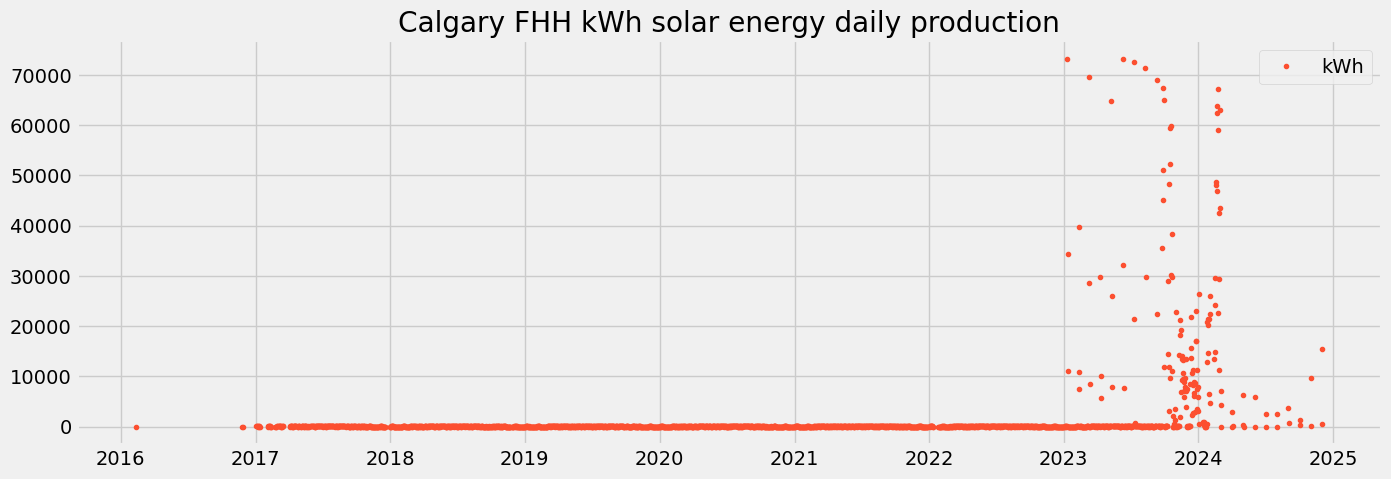

In [ ]:
daily_production.plot(style='.', figsize=(15, 5), color=color_pal[1], title='Calgary FHH kWh solar energy daily production')

<AxesSubplot: title={'center': 'Calgary FHH kWh solar energy hourly production'}, xlabel='date'>

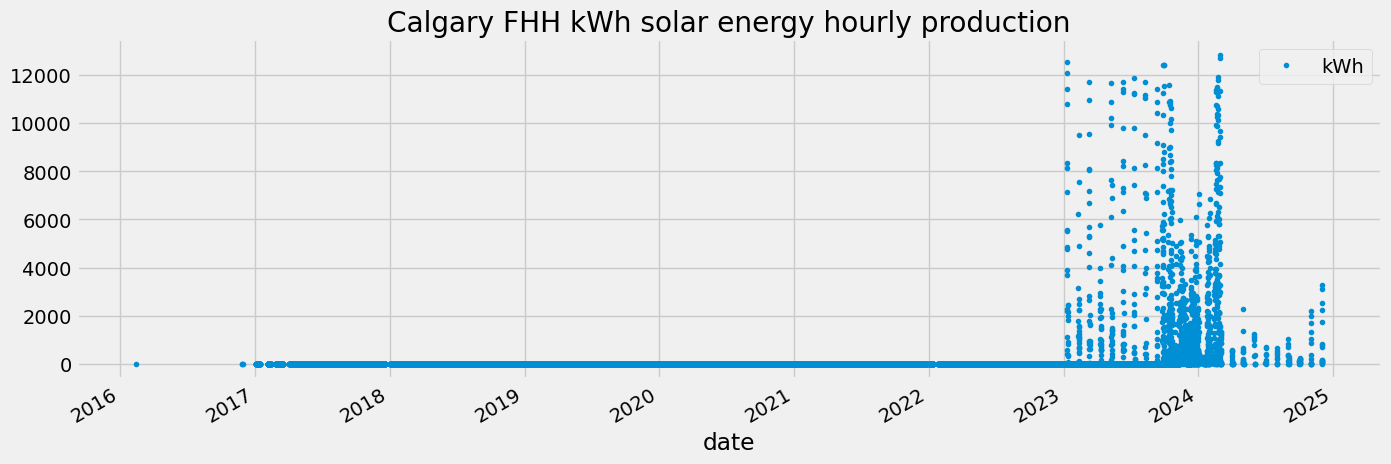

In [ ]:
hourly_production.plot(style='.', figsize=(15, 5), color=color_pal[0], title='Calgary FHH kWh solar energy hourly production')

<AxesSubplot: xlabel='date'>

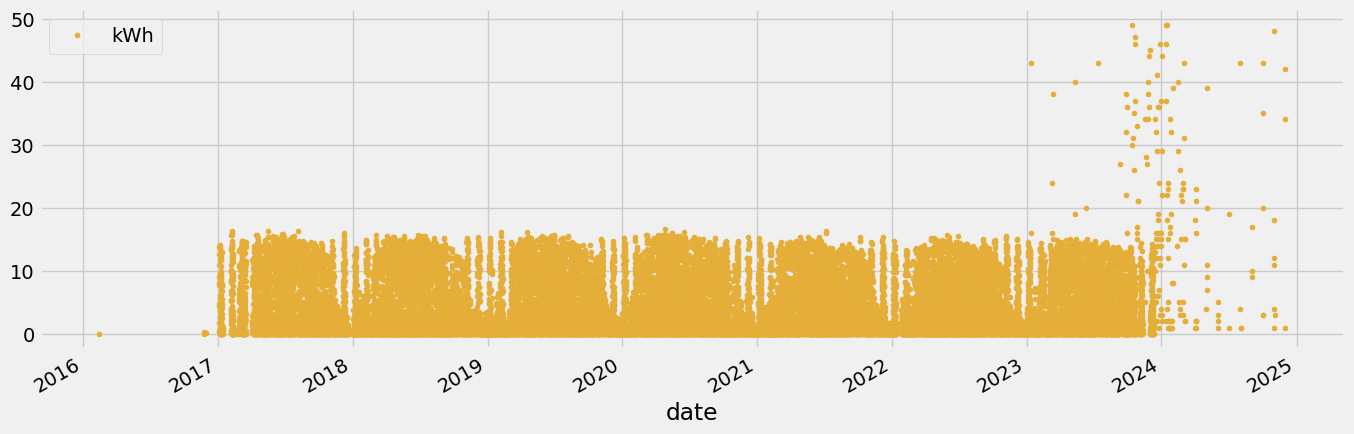

In [ ]:
hourly_production.query('kWh < 50').plot(style='.', figsize=(15, 5), color=color_pal[2])

In [ ]:
#run a copy on the dataset
#take records with kWh < 20 from 2017 to 2022
# Assuming hourly_production has a datetime index and a 'kWh' column
df = hourly_production[(hourly_production.index.year >= 2017) &
                                      (hourly_production.index.year <= 2022) &
                                      (hourly_production['kWh'] < 20)].copy()



## Train/Test Split

### Time Series Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

#set the gap to prevent data leakage where the model might learn from future data points that are close in time to the training set
tss = TimeSeriesSplit(n_splits=5, test_size=24*182, gap=24)


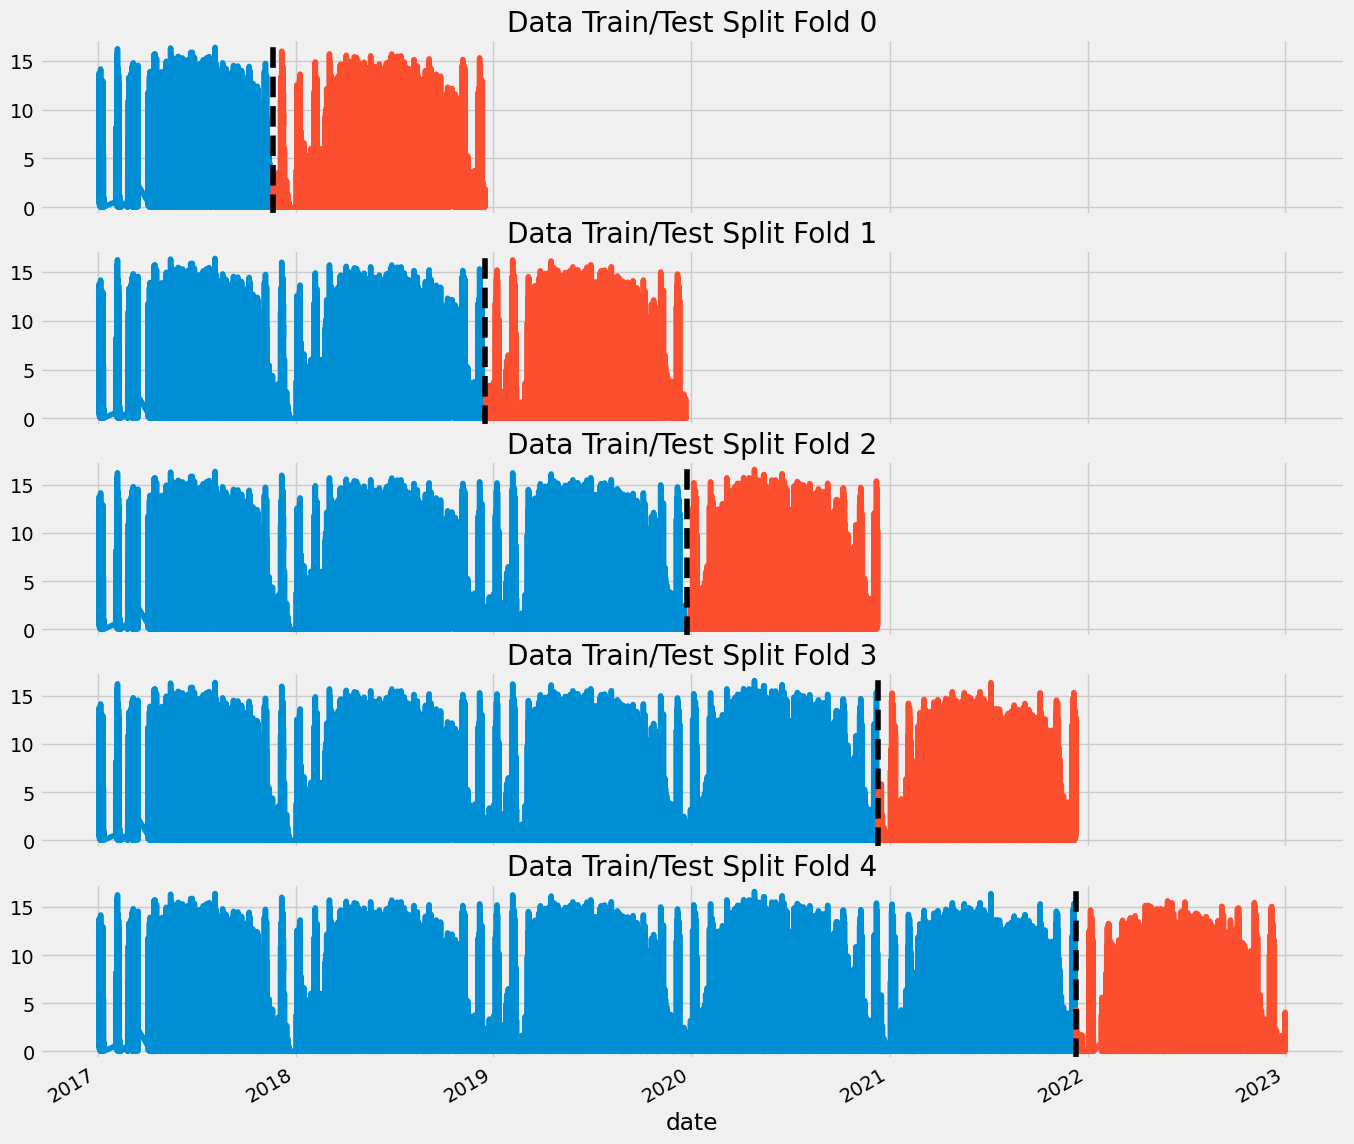

In [ ]:
df = df.sort_index()
#hourly_production = hourly_production.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['kWh'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['kWh'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Train/Test Split

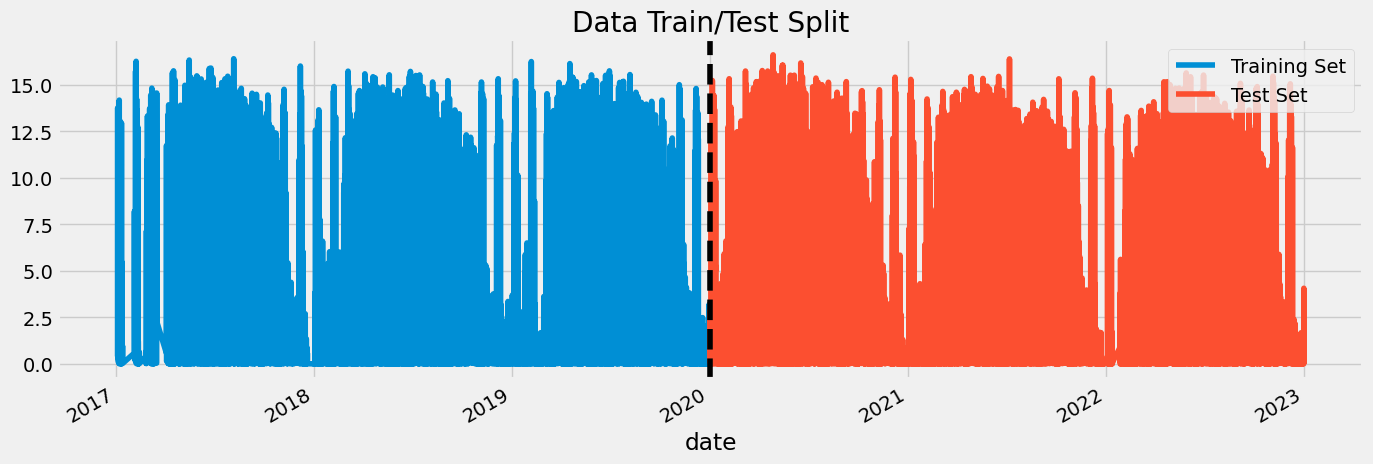

In [ ]:
train = df.loc[df.index < '01-01-2020']
test = df.loc[df.index >= '01-01-2020']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2020', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

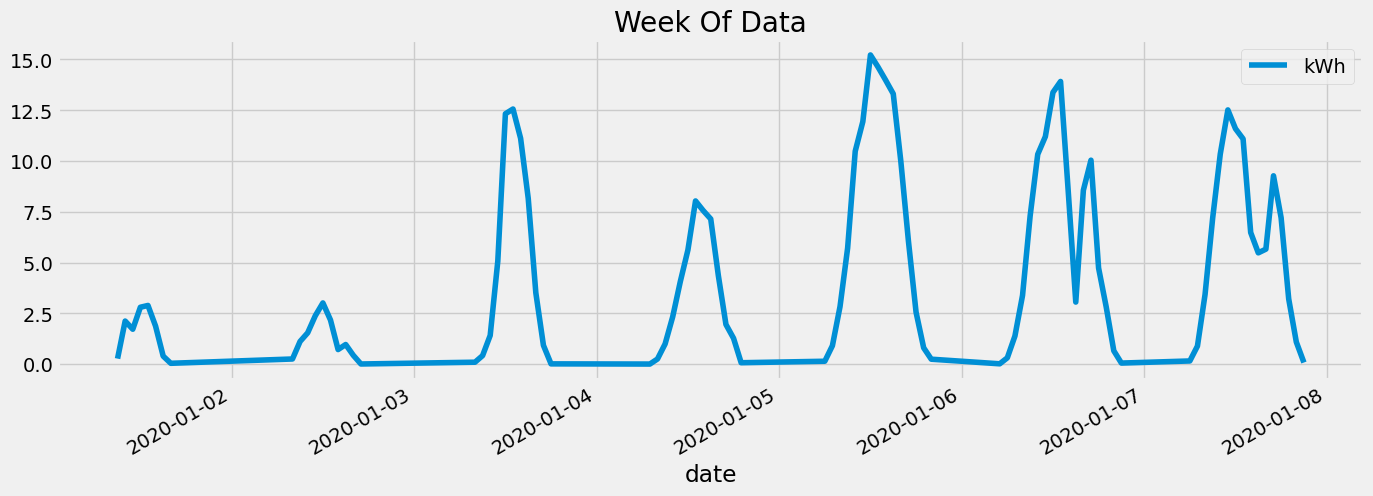

In [ ]:
#viz week of data
df.loc[(df.index > '01-01-2020') & (df.index < '01-08-2020')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## Feature Creation

### Time Series Features

In [ ]:
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### Lag Features


In [ ]:
#to look back in the past, however many days. what was the target(x) days in the past

In [ ]:
target_map = df['kWh'].to_dict()

In [ ]:
target_map

{Timestamp('2017-01-03 08:00:00'): 0.404,
 Timestamp('2017-01-03 09:00:00'): 1.722,
 Timestamp('2017-01-03 10:00:00'): 4.365,
 Timestamp('2017-01-03 11:00:00'): 7.997,
 Timestamp('2017-01-03 12:00:00'): 12.632,
 Timestamp('2017-01-03 13:00:00'): 13.753,
 Timestamp('2017-01-03 14:00:00'): 10.991,
 Timestamp('2017-01-03 15:00:00'): 8.977,
 Timestamp('2017-01-03 16:00:00'): 7.685,
 Timestamp('2017-01-03 17:00:00'): 4.691,
 Timestamp('2017-01-03 18:00:00'): 0.314,
 Timestamp('2017-01-05 06:00:00'): 0.069,
 Timestamp('2017-01-05 07:00:00'): 0.89,
 Timestamp('2017-01-05 08:00:00'): 3.789,
 Timestamp('2017-01-05 09:00:00'): 8.431,
 Timestamp('2017-01-05 10:00:00'): 12.071,
 Timestamp('2017-01-05 11:00:00'): 9.695,
 Timestamp('2017-01-05 12:00:00'): 13.303,
 Timestamp('2017-01-05 13:00:00'): 12.709,
 Timestamp('2017-01-05 14:00:00'): 13.565,
 Timestamp('2017-01-05 15:00:00'): 9.518,
 Timestamp('2017-01-05 16:00:00'): 9.053,
 Timestamp('2017-01-05 17:00:00'): 4.179,
 Timestamp('2017-01-05 18:00

In [ ]:
#364 is divisible by 7 and will give you the exact same day of the week
def lag_features(df):
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index -pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = lag_features(df)


## Feature Relation Vizulisation

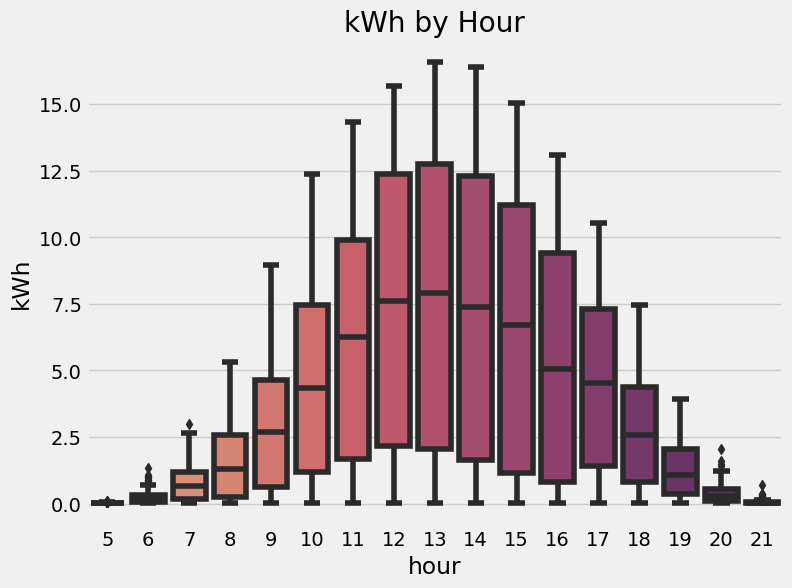

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=df, x='hour', y='kWh', palette='flare')
ax.set_title('kWh by Hour')
plt.show()

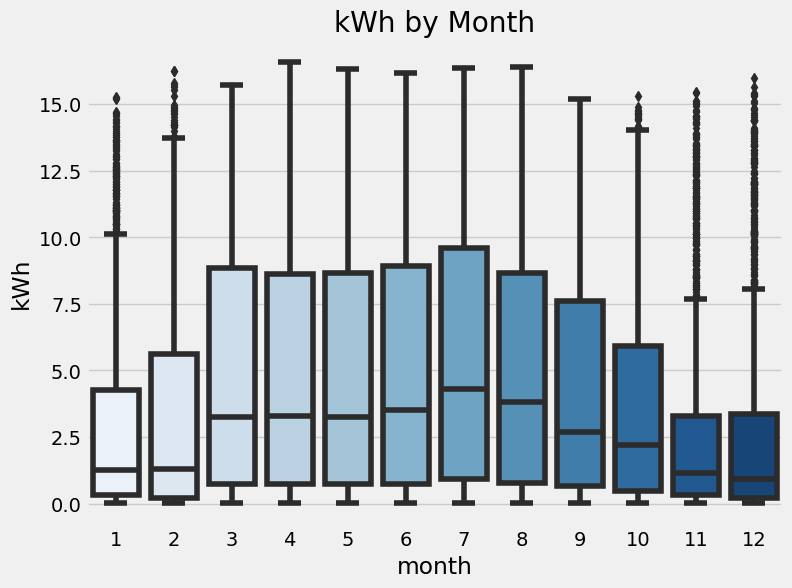

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=df, x='month', y='kWh', palette='Blues')
ax.set_title('kWh by Month')
plt.show()

## Training using Cross Validation

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*182, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'kWh'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:6.57025	validation_1-rmse:5.82736
[100]	validation_0-rmse:3.96631	validation_1-rmse:3.87455
[200]	validation_0-rmse:3.37575	validation_1-rmse:3.68412


U:\Python39\site-packages\xgboost\core.py:160: UserWarning: [15:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:3.17819	validation_1-rmse:3.65687
[400]	validation_0-rmse:3.05740	validation_1-rmse:3.61475
[500]	validation_0-rmse:2.95425	validation_1-rmse:3.57367
[600]	validation_0-rmse:2.88283	validation_1-rmse:3.51519
[700]	validation_0-rmse:2.83049	validation_1-rmse:3.48683
[800]	validation_0-rmse:2.77397	validation_1-rmse:3.46033
[900]	validation_0-rmse:2.72978	validation_1-rmse:3.45209
[999]	validation_0-rmse:2.69116	validation_1-rmse:3.43874
[0]	validation_0-rmse:6.15275	validation_1-rmse:5.67325
[100]	validation_0-rmse:4.06688	validation_1-rmse:3.67082
[200]	validation_0-rmse:3.49275	validation_1-rmse:3.29324


U:\Python39\site-packages\xgboost\core.py:160: UserWarning: [15:19:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:3.28265	validation_1-rmse:3.19289
[400]	validation_0-rmse:3.17395	validation_1-rmse:3.15277
[500]	validation_0-rmse:3.10194	validation_1-rmse:3.12923
[600]	validation_0-rmse:3.04986	validation_1-rmse:3.12134
[700]	validation_0-rmse:3.00164	validation_1-rmse:3.11210
[800]	validation_0-rmse:2.96391	validation_1-rmse:3.10455
[851]	validation_0-rmse:2.94807	validation_1-rmse:3.10506
[0]	validation_0-rmse:5.98192	validation_1-rmse:5.92735
[100]	validation_0-rmse:4.01517	validation_1-rmse:4.07445
[200]	validation_0-rmse:3.46096	validation_1-rmse:3.66773


U:\Python39\site-packages\xgboost\core.py:160: UserWarning: [15:19:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:3.26324	validation_1-rmse:3.58141
[400]	validation_0-rmse:3.16008	validation_1-rmse:3.55604
[500]	validation_0-rmse:3.10034	validation_1-rmse:3.54448
[600]	validation_0-rmse:3.06140	validation_1-rmse:3.54379
[608]	validation_0-rmse:3.05877	validation_1-rmse:3.54434
[0]	validation_0-rmse:5.95968	validation_1-rmse:5.79310
[100]	validation_0-rmse:4.03682	validation_1-rmse:3.76994


U:\Python39\site-packages\xgboost\core.py:160: UserWarning: [15:19:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:3.52106	validation_1-rmse:3.28028
[300]	validation_0-rmse:3.34687	validation_1-rmse:3.14709
[400]	validation_0-rmse:3.25689	validation_1-rmse:3.08712
[500]	validation_0-rmse:3.19773	validation_1-rmse:3.05486
[600]	validation_0-rmse:3.15818	validation_1-rmse:3.03960
[651]	validation_0-rmse:3.13985	validation_1-rmse:3.04052
[0]	validation_0-rmse:5.92819	validation_1-rmse:5.59504
[100]	validation_0-rmse:3.99239	validation_1-rmse:3.55327


U:\Python39\site-packages\xgboost\core.py:160: UserWarning: [15:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:3.47441	validation_1-rmse:3.08111
[300]	validation_0-rmse:3.29816	validation_1-rmse:2.95527
[400]	validation_0-rmse:3.21455	validation_1-rmse:2.90445
[500]	validation_0-rmse:3.16015	validation_1-rmse:2.86995
[600]	validation_0-rmse:3.12402	validation_1-rmse:2.84799
[700]	validation_0-rmse:3.09538	validation_1-rmse:2.83115
[800]	validation_0-rmse:3.07172	validation_1-rmse:2.81694
[900]	validation_0-rmse:3.04896	validation_1-rmse:2.80213
[999]	validation_0-rmse:3.02531	validation_1-rmse:2.78421


## Feature Importance

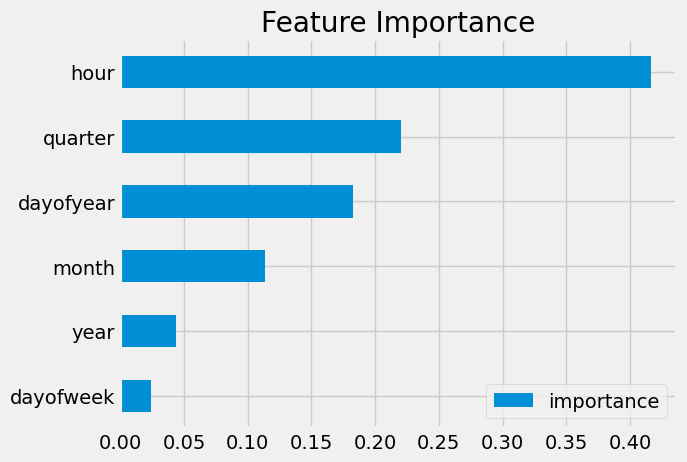

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_,
                 columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

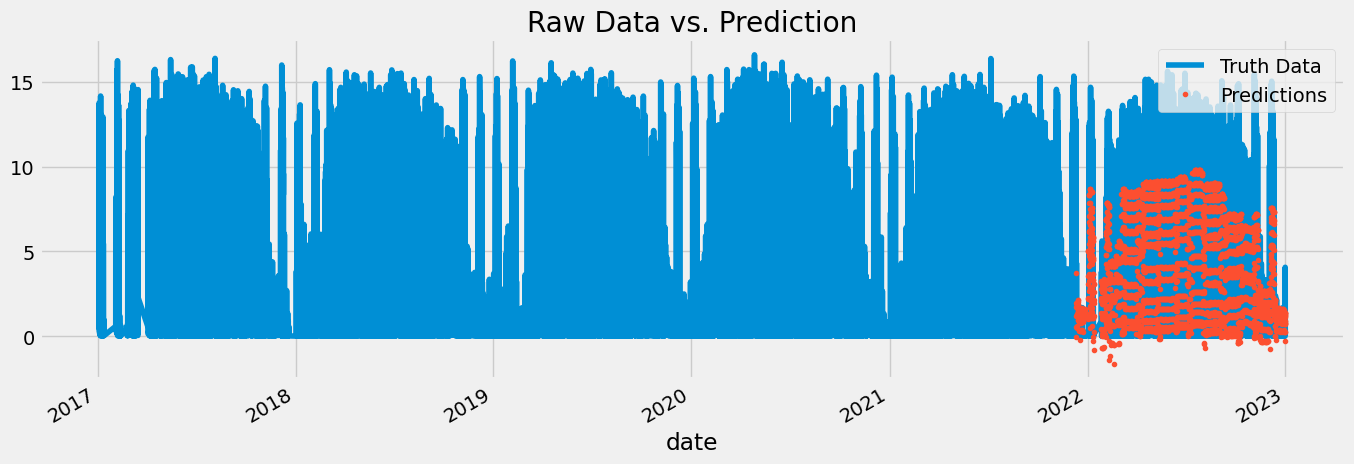

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['kWh']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data vs. Prediction')
plt.show()

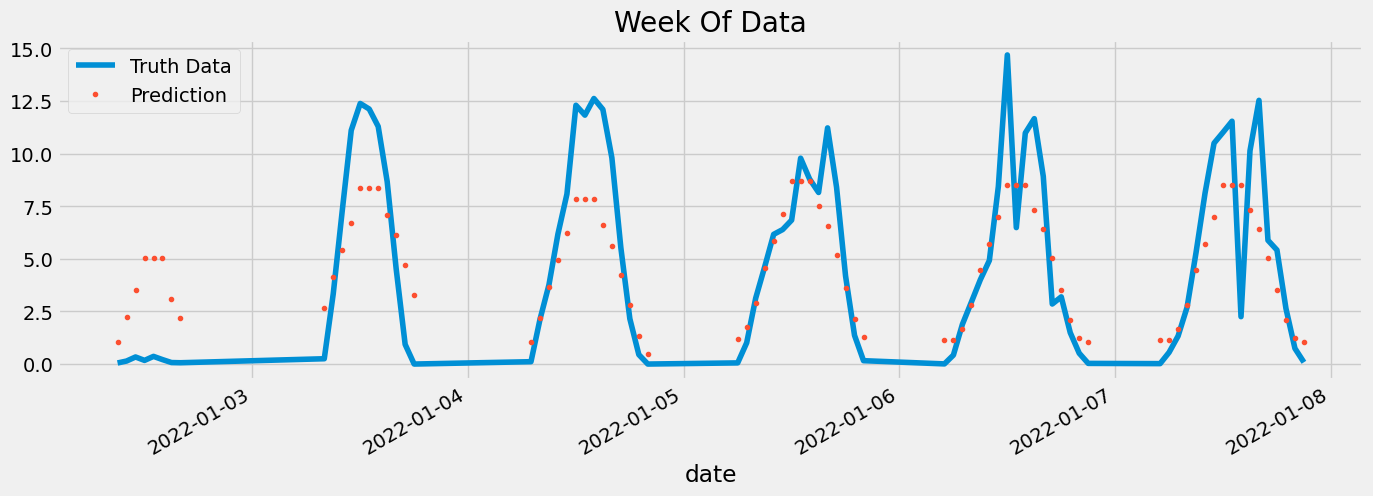

In [ ]:
ax = df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')]['kWh'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## RMSE Score

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.1813
Fold scores:[3.4385989461283004, 3.1041923482087688, 3.5404141224617227, 3.039311169626175, 2.784141270378541]


In [ ]:
test['prediction'] = reg.predict(X_test)

score = np.sqrt(mean_squared_error(test['kWh'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2.78


## Predict the future

In [ ]:
# Create future dataframe
future = pd.date_range('2023-01-03','2024-01-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = lag_features(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

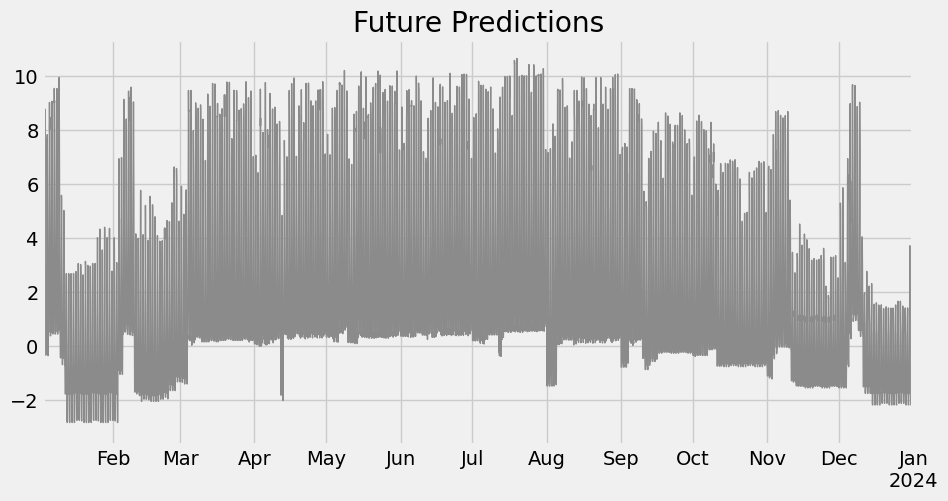

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()